# Halo to Halo transfer

This example detail a procedure to compute Halo to Halo transfers in the Earth-Moon CRTBP.


## Configuration

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
import r3bpy
from r3bpy.main import Problem, Manifold
import r3bpy.core as constants
from r3bpy.visu import plot_system
from r3bpy.orbits import HaloOrbit, HaloOrbitFamily, print_info

Let's import the usual modules.

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## System definition

We now defined the restricted three body problem parameters.

In [4]:
m1 = constants.MU_EARTH
r12 = constants.DISTANCE_EARTH_MOON
m2 = constants.MU_MOON
problem = Problem(m1, m2, r12)
mu_ratio = problem.get_mu_ratio()

Let's have a model representation of the system

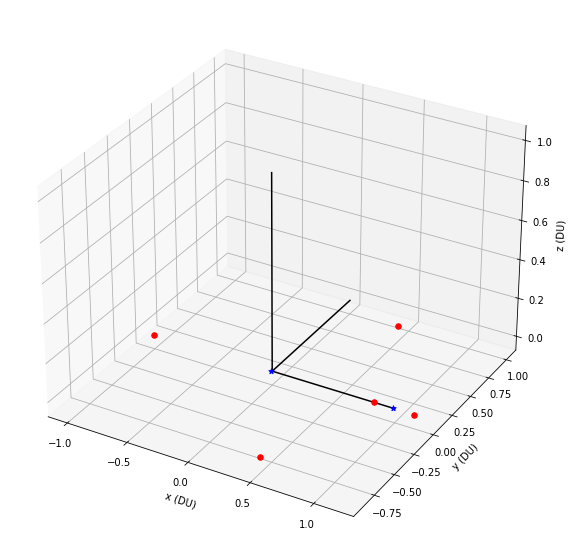

In [5]:
ax = plot_system(problem, is2d=False, withAxes=True)

We would now compute and plot the Libration points of this system, as well as a Halo orbit. The purpose would be to evaluate the possibility of a vantage point from the Halo orbit on both asteroids.

## Halo orbits

In [6]:
libration_point = problem.get_libration_point_info(r3bpy.main.L2)

We construct two Halo orbits around L2: a Southern Halo orbit, and a Northern Halo orbit

In [7]:
# amplitude of the departure Halo orbit
Ax = 2000 / r12
halo = HaloOrbit(libration_point, HaloOrbitFamily.NORTHERN)
halo_departure = halo.find_orbit(Ax)
orbit_period_dep = halo_departure.period
print_info(halo_departure)
print("Orbit amplitudes: ", halo_departure.Ax, halo_departure.Ay, halo_departure.Az)

Orbit type           : halo
      period         : 3.415531
      Libration Point: L1
      Primaries      :  
Orbit amplitudes:  0.029734386686155197 0.0 5.185484790973108e-06


In [8]:
# amplitude of the departure Halo orbit
Ax = 2000 / r12
halo = HaloOrbit(libration_point, HaloOrbitFamily.SOUTHERN)
halo_arrival = halo.find_orbit(Ax)
orbit_period_arr = halo_arrival.period
print_info(halo_arrival)
print("Orbit amplitudes: ", halo_arrival.Ax, halo_arrival.Ay, halo_arrival.Az)

Orbit type           : halo
      period         : 3.415531
      Libration Point: L1
      Primaries      :  
Orbit amplitudes:  0.029734386686155197 0.0 5.185484790973108e-06


In [9]:
_, xyz_halo_dep = halo_departure.propagate([0, orbit_period_dep])  
xyz_halo_dep = np.array(xyz_halo_dep)
_, xyz_halo_arr = halo_arrival.propagate([0, orbit_period_arr])  
xyz_halo_arr = np.array(xyz_halo_arr)

<Axes3DSubplot:xlabel='x (DU)', ylabel='y (DU)'>

<Figure size 720x720 with 0 Axes>

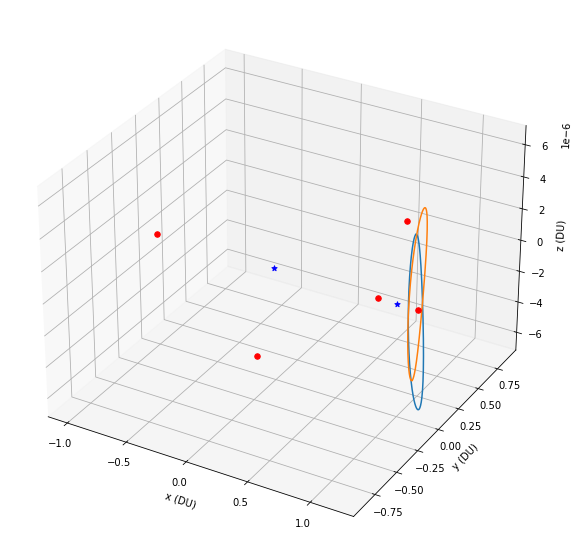

In [10]:
#%matplotlib widget
from r3bpy.visu import plot_trajectory

fig = plt.figure()
ax = plot_system(problem, is2d=False)
plot_trajectory(xyz_halo_dep, ax=ax)
plot_trajectory(xyz_halo_arr, ax=ax)

## Transfer

Now that we have defined initial and arrival orbits, we can compute the best transfer to go from halo_departure to halo_arrival. This transfer is a two-impulse transfer
(an impulse to leave the departure Halo orbit, and an impulse to break and insert into the arrival Halo orbit)
This can be well solved through the formulation of the Lambert's problem. So let's create a Lambert's problem solver!

In [11]:
from r3bpy.main import LambertProblem
solver = LambertProblem(problem.get_mu_ratio())

The Lambert's problem is defined as finding the solution that goes from one position vector to another in a fixed given time.

We have then to use the propagated solution points xyz_halo_dep and xyz_halo_arr.

In [12]:
r0 = xyz_halo_dep[0][0:3]
v0 = xyz_halo_dep[0][4:6]
rf = xyz_halo_arr[0][0:3]
v0 = xyz_halo_arr[0][4:6]

To find solution, we can fix the time of flight.

In [13]:
tof=0.68

In [14]:
v1, v2 = solver.solve(list(xyz_halo_dep[0]), list(rf), tof)
print(v1)
print(v2)

[ 8.13496631e-02  1.80770897e-02 -1.05091894e-05]
[-8.13496631e-02  1.80770897e-02 -1.05091894e-05]


Naively, we took "random" points on the departure and arrival orbit, but in reality we should perform the exercice with a given objective such as the total dV, or the time of flight, and select the departure and arrival points that minimise the objective function.

Let's propagate this solution.

In [15]:
from r3bpy.main import Propagator
x0 = [r0[0], r0[1], r0[2], v1[0], v1[1], v1[2]] # FIXME
        
propagator = Propagator(problem.get_mu_ratio())
t_transfer, xyz_transfer = propagator.propagate(x0, [0, tof])

And plot

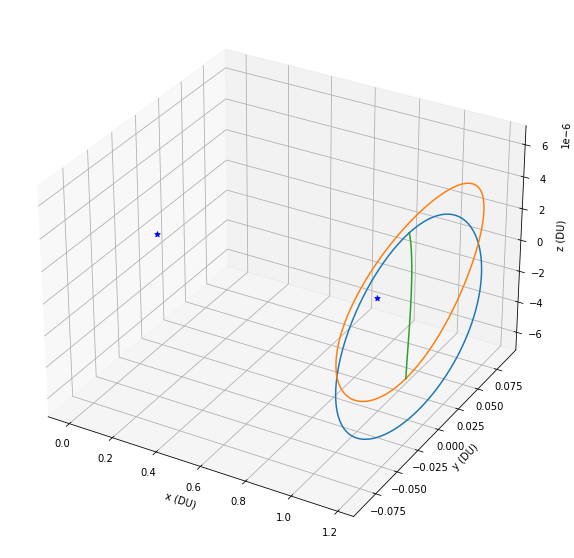

In [16]:
ax = plot_system(problem, is2d=False, withPrimaries=True, withTriangularPoints=False, withCollinearPoints=False)
plot_trajectory(xyz_halo_dep, ax=ax)
plot_trajectory(xyz_halo_arr, ax=ax)
plot_trajectory(xyz_transfer, ax=ax)
plt.show()


As said before, and clearly, we did not choose the best points! We would have to go iteratively through the orbits.

We introduce the parameter $\tau$ in [0,1] to go through the orbit position. We will compute all the transfers between the orbits for different values of $\tau$, with a step of 0.1. We will then pick the one "best".

In [17]:
sols = solver.solve_tau(halo_departure, halo_arrival, tof, 0.1)

We can plot all the computed transfer.

Let's print the first 20 solutions.

In [18]:
r3bpy.main.print_lambert_tau(sols, n=20)

#   | tau_1 tau_2 |     dv1       dv2  |  dv_total
  0| 0.0  0.0  |     0.178    0.178 |    0.355
  1| 0.0  0.0  |    0.0628    0.108 |    0.171
  2| 0.0  0.0  |  0.000293 0.000944 |    0.00124
  3| 0.0  0.0  |    0.0176   0.0873 |    0.105
  4| 0.0  0.0  |    0.0698     0.13 |    0.2
  5| 0.0  0.0  |     0.156    0.127 |    0.283
  6| 0.0  0.0  |     0.246    0.088 |    0.334
  7| 0.0  0.0  |      0.31   0.0616 |    0.372
  8| 0.0  0.0  |     0.328    0.108 |    0.435
  9| 0.0  0.0  |     0.283    0.164 |    0.447
 10| 0.1  0.1  |     0.164    0.283 |    0.447
 11| 0.1  0.1  |    0.0568    0.201 |    0.258
 12| 0.1  0.1  |      0.02   0.0857 |    0.106
 13| 0.1  0.1  |  0.000381 0.000582 |    0.000963
 14| 0.1  0.1  |    0.0632   0.0408 |    0.104
 15| 0.1  0.1  |     0.153   0.0433 |    0.197
 16| 0.1  0.1  |     0.244   0.0621 |    0.306
 17| 0.1  0.1  |     0.307    0.129 |    0.437
 18| 0.1  0.1  |     0.321    0.208 |    0.529
 19| 0.1  0.1  |     0.272    0.271 |    0.543
 20| 0

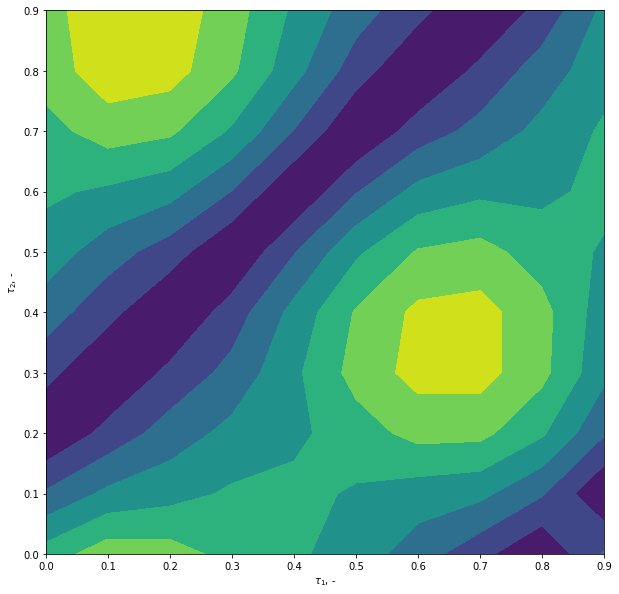

In [19]:
tau1 = []
tau2 = []
dv = []
for sol in sols:
    dv1 = np.linalg.norm(sol.get_dv1());
    dv2 = np.linalg.norm(sol.get_dv2())
    tau1.append(sol.tau1)
    tau2.append(sol.tau2)
    dv.append(dv1+dv2)

x = np.reshape(tau1, (10,10))
y = np.reshape(tau2, (10,10)).T
z = np.reshape(dv, (10,10))

fig = plt.figure()
ax = fig.add_subplot()
cs = ax.contourf(x, y, z)
ax.set_xlabel('$\\tau_1$, -')
ax.set_ylabel('$\\tau_2$, -')
plt.show()

And choose the one with, for instance, the lowest $\Delta V$. From the table, #24 seems a good candidate.

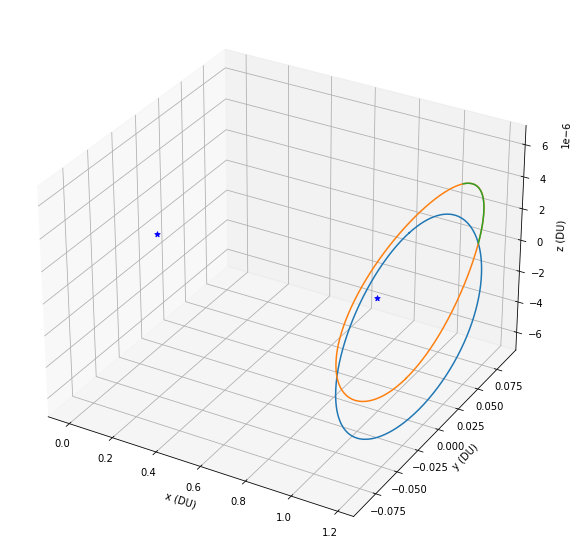

In [20]:
ax = plot_system(problem, is2d=False, withPrimaries=True, withTriangularPoints=False, withCollinearPoints=False)
plot_trajectory(xyz_halo_dep, ax=ax)
plot_trajectory(xyz_halo_arr, ax=ax)

propagator = Propagator(problem.get_mu_ratio())

sol = sols[24]
x0 = list(sol.get_init_state())
_, xyz_transfer = propagator.propagate(x0, [0, sol.tof])
plot_trajectory(xyz_transfer, ax=ax)
plt.show()

Now, to make the transfer a bit more efficient, the remaining degree of freedom of this two-impulse transfer is the time of flight.

voilà!